In [1]:
from catboost import Pool, CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# используем датасет https://www.kaggle.com/datasets/blastchar/telco-customer-churn
df = pd.read_csv('data.csv')

In [3]:
df = df.drop(['customerID'], axis=1)

In [4]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [6]:
# Некоторые значения в TotalCharges потеряны
indicies_to_remove = []

for ind, i in enumerate(df['TotalCharges']):
    try:
        _ = float(i)
    except Exception:
        print("Wrong value with char code =", ord(i), ", index =", ind)
        indicies_to_remove.append(ind)

df = df.drop(df.index[indicies_to_remove])
print('\nWrong values have been deleted')

Wrong value with char code = 32 , index = 488
Wrong value with char code = 32 , index = 753
Wrong value with char code = 32 , index = 936
Wrong value with char code = 32 , index = 1082
Wrong value with char code = 32 , index = 1340
Wrong value with char code = 32 , index = 3331
Wrong value with char code = 32 , index = 3826
Wrong value with char code = 32 , index = 4380
Wrong value with char code = 32 , index = 5218
Wrong value with char code = 32 , index = 6670
Wrong value with char code = 32 , index = 6754

Wrong values have been deleted


In [38]:
df['TotalCharges'] = df['TotalCharges'].astype('float')

In [8]:
# Используем LabelEncoder для кодирования целевой переменной
le = preprocessing.LabelEncoder()
df[['Churn']] = df[['Churn']].apply(le.fit_transform)

# Некоторые значения закодируем вручную
df = df.replace(['No internet service', 'No phone service', 'No', 'Yes'], [-1, -1, 0, 1])
df = df.replace(['Female', 'Male'], [0, 1])

# На указанных ниже используем OneHot Encoding
df = pd.get_dummies(df, prefix=['InternetService','Contract', 'PaymentMethod'], 
                      columns = ['InternetService','Contract', 'PaymentMethod'], drop_first=True).astype('int')
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,-1,0,1,0,...,29,29,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,1,0,1,...,56,1889,0,1,0,1,0,0,0,1
2,1,0,0,0,2,1,0,1,1,0,...,53,108,1,1,0,0,0,0,0,1
3,1,0,0,0,45,0,-1,1,0,1,...,42,1840,0,1,0,1,0,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,70,151,1,0,1,0,0,0,1,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                                 Non-Null Count  Dtype
---  ------                                 --------------  -----
 0   gender                                 7032 non-null   int32
 1   SeniorCitizen                          7032 non-null   int32
 2   Partner                                7032 non-null   int32
 3   Dependents                             7032 non-null   int32
 4   tenure                                 7032 non-null   int32
 5   PhoneService                           7032 non-null   int32
 6   MultipleLines                          7032 non-null   int32
 7   OnlineSecurity                         7032 non-null   int32
 8   OnlineBackup                           7032 non-null   int32
 9   DeviceProtection                       7032 non-null   int32
 10  TechSupport                            7032 non-null   int32
 11  StreamingTV                   

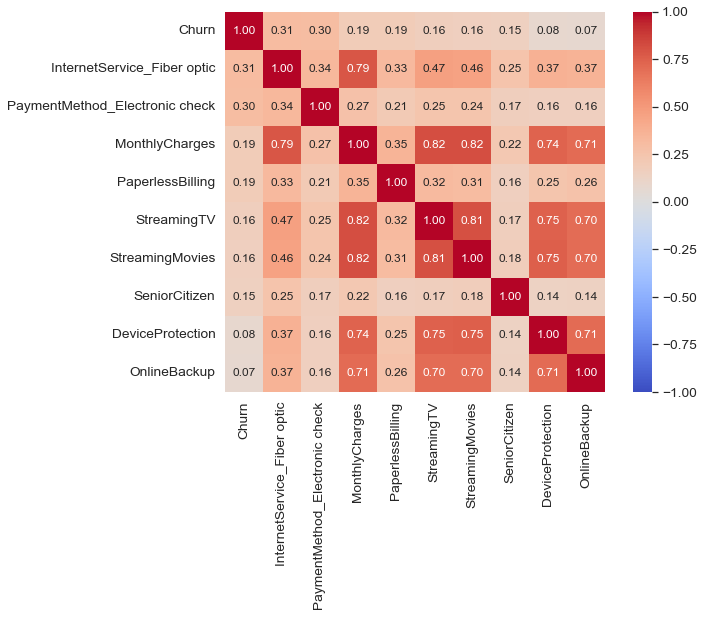

In [40]:
k = 10
corrmat = df.corr()
cols = corrmat.nlargest(k, 'Churn')['Churn'].index.tolist()
cm = np.corrcoef(df[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12},\
                yticklabels=cols, xticklabels=cols, vmin=-1, center=0,\
                    cmap=sns.color_palette('coolwarm',1000))
plt.show()

### Наблюдения 
Заметим, что от наличия доп. услуг и т.д., месячная оплата увеличивается, что звучит логично. Так же с целевой переменной лучше всего коррелирует наличие у пользователей оптоволокна. Возможно часть клиентов оно не удовлетворило, и они ушли от компании (напомню значения для категориальных переменных: Наличие оптоволокна - 1, Клиент ушёл от компании - 1). Помним, что большие значения при корреляции первого признака, соответствуют большим значениям второго.

In [10]:
# Используем StandardScaler для нормализации данных.
scaler = StandardScaler()

In [11]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Churn'], axis=1), 
                                                    df['Churn'], test_size=0.30, 
                                                    random_state=42, stratify=df['Churn'])

In [12]:
X_train

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaperlessBilling,MonthlyCharges,TotalCharges,InternetService_DSL,InternetService_Fiber optic,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
4499,0,0,0,1,-0.832064,1,1,1,0,0,...,1,0.454274,-0.606118,0,1,0,0,0,1,0
1933,1,0,0,0,-0.506113,1,0,-1,-1,-1,...,1,-1.506737,-0.824064,0,0,1,0,0,0,1
4668,0,0,0,1,-1.239504,1,0,1,0,0,...,1,-0.110763,-0.952009,1,0,0,0,1,0,0
5681,0,1,1,0,0.064303,1,0,0,0,1,...,0,-0.011051,-0.078015,1,0,1,0,0,0,0
3610,0,0,0,0,-0.832064,1,1,0,0,1,...,1,1.185498,-0.493615,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161,1,0,0,1,-0.383881,1,0,0,1,0,...,0,-0.343425,-0.428319,1,0,0,0,0,1,0
3451,1,1,1,0,1.327365,1,0,0,0,0,...,1,0.188374,1.002454,0,1,1,0,0,0,0
4135,0,0,1,1,0.145791,1,1,1,1,1,...,1,0.919598,0.483617,1,0,0,1,1,0,0
4249,0,0,1,1,-0.913552,1,0,0,1,1,...,1,0.022187,-0.715973,1,0,1,0,0,0,1


# Testing Default Params

In [13]:
def write_score_to_file(score, name):
    f = open('scores.txt', 'a')
    f.write(f'{score}, {name}')
    f.write('\n')
    f.close()

In [16]:
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)
score = f1_score(y_test, y_pred)
write_score_to_file(score, 'LGBMClassifier_default')

In [17]:
cbr = CatBoostClassifier(logging_level='Silent')
cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_test)
score = f1_score(y_test, y_pred)
print(score)
write_score_to_file(score, 'CatBoostClassifier_default')

0.5583250249252243


In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
score = f1_score(y_test, y_pred)
print(score)
write_score_to_file(score, 'XGBClassifier_default')

[13:59:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.5378640776699029


In [19]:
skl = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = skl.predict(X_test)
score = f1_score(y_test, y_pred)
print(score)
write_score_to_file(score, 'GradientBoosting_default')

0.5533199195171026


# Testing GridSearchCV

In [14]:
from sklearn.model_selection import GridSearchCV

def estimate_grid_search(model, grid, X=X_train, y=y_train, name=None):
    clf = GridSearchCV(model, grid, verbose = 1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"Best params: {clf.best_params_}")
    score = f1_score(y_test, y_pred)
    print(score)
    write_score_to_file(score, name)

In [17]:
grid = {'learning_rate': [i for i in np.arange(0.01, 0.05, 0.01)],
        'depth': [i for i in range(2, 11)],
        'iterations': [i for i in range(10, 101, 10)],
        'l2_leaf_reg': [3, 4, 5, 7, 10]
       }
cbc = CatBoostClassifier()
estimate_grid_search(cbc, grid, X=X_train, y=y_train, name='CatBoost_tuned')
print(f"Best params: {clf.best_params_}")

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best params: {'depth': 5, 'iterations': 90, 'l2_leaf_reg': 7, 'learning_rate': 0.04}
0.5501551189245089


In [18]:
%%time
grid = {'learning_rate': [i for i in np.arange(0.01, 0.05, 0.01)],
        'max_depth': [-1] + [i for i in range(2, 11)],
        'reg_lambda': [1, 3, 5, 7, 9],
        'n_estimators': [i for i in range(10, 101, 10)]}
lgbm = lgb.LGBMClassifier()
estimate_grid_search(lgbm, grid, X=X_train, y=y_train, name='LGBM_tuned')

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Best params: {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 100, 'reg_lambda': 7}
0.5578093306288032
Wall time: 5min 31s


In [19]:
%%time
grid = {'learning_rate': [i for i in np.arange(0.01, 0.05, 0.01)],
        'n_estimators': [i for i in range(10, 101, 10)],
        'max_depth': [i for i in range(2, 11)],
        'subsample':[0.2, 0.5, 0.7]}
skl = GradientBoostingClassifier()
estimate_grid_search(skl, grid, X=X_train, y=y_train, name='GradBoostSklearn_tuned')

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best params: {'learning_rate': 0.04, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.2}
0.5544147843942505
Wall time: 38min 23s


In [20]:
%%time
grid = {'learning_rate': [i for i in np.arange(0.01, 0.05, 0.01)],
        'n_estimators': [i for i in range(10, 101, 10)],
        'max_depth': [i for i in range(2, 11)],
        'subsample':[0.2, 0.5, 0.7]}
xgb = XGBClassifier(verbosity=0, use_label_encoder=False)
estimate_grid_search(xgb, grid, X=X_train, y=y_train, name='XGB_tuned')

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Best params: {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.2}
0.5644670050761421
Wall time: 14min 48s


## Оценка результатов точности модели

In [21]:
scores_df = pd.read_csv('scores.txt', sep=",", header=None)
scores_df.columns = ["Score", "model"]
scores_df

,Score,model
0,0.567541,LGBMClassifier_default
1,0.558325,CatBoostClassifier_default
2,0.537864,XGBClassifier_default
3,0.553320,GradientBoosting_default
4,0.550155,CatBoost_tuned
5,0.557809,LGBM_tuned
6,0.554415,GradBoostSklearn_tuned
7,0.564467,XGB_tuned


In [36]:
# Лучший среди дефолтных
scores_df[scores_df["model"].str.match(r'.*_default')].nlargest(1, ['Score'])

,Score,model
0,0.567541,LGBMClassifier_default


In [37]:
# Лучший среди всех
scores_df.nlargest(1, ['Score'])

,Score,model
0,0.567541,LGBMClassifier_default


### Вывод: 
Среди моделей с параметрами "по умолчанию" наивысший результат показал LGBMClassifier_default. Наилучший резутьтат f1_score показал также LGBMClassifier_default. В целом среди всех моделей наблюдается небольшая разность

In [45]:
df = pd.read_csv('data.csv')

In [46]:
df = df.drop(['customerID'], axis=1)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Churn'], axis=1), 
                                                    df['Churn'], test_size=0.30, 
                                                    random_state=42, stratify=df['Churn'])

cbr = CatBoostClassifier(logging_level='Silent')


cols = []
for col in df.columns:
    if df[col].dtype == 'object': 
        cols.append(col)

pool_train = Pool(X_train, y_train,
                  cat_features = cols[:-1])

pool_test = Pool(X_test, cat_features = cols[:-1])

cbr.fit(pool_train)
y_pred = cbr.predict(pool_test)
score = f1_score(y_test, y_pred.tolist())
print(score)

ValueError: pos_label=1 is not a valid label. It should be one of ['No', 'Yes']